###IMPORTS

---





In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds

###DATASET

---



In [2]:
columns = ["sentiment", "id", "date", "query", "user", "tweet"]

dataset = pd.read_csv('data.csv', 
                      header=None,
                      names=columns,
                      engine="python",
                      encoding="latin1",
                      error_bad_lines=False)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
dataset.drop(["id", "date", "query", "user"],
          axis=1,
          inplace=True)

In [4]:
dataset.head()

,sentiment,tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [5]:
dataset["sentiment"].unique()

array([0, 4, 2])

In [6]:
# neutral sentiment - not needed (for now)
dataset.loc[dataset["sentiment"] == 2]

,sentiment,tweet
1600009,2,Check this video out -- President Obama at the...
1600029,2,need suggestions for a good IR filter for my c...
1600030,2,@surfit: I just checked my google for my busin...
1600044,2,is in San Francisco at Bay to Breakers.
1600045,2,just landed at San Francisco
...,...,...
1600474,2,has a date with bobby flay and gut fieri from ...
1600482,2,How to Track Iran with Social Media: http://bi...
1600485,2,Twitter Stock buzz: $AAPL $ES_F $SPY $SPX $PAL...
1600487,2,@johncmayer is Bobby Flay joining you?


In [7]:
dataset.drop(dataset.loc[dataset["sentiment"]==2].index, inplace=True)

In [8]:
# change labels
data_labels = dataset["sentiment"].values
data_labels[data_labels == 4] = 1

In [9]:
dataset["sentiment"].unique()

array([0, 1])

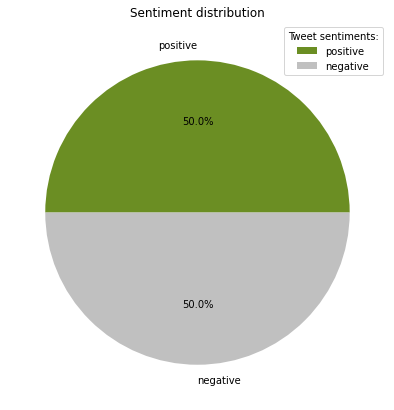

In [10]:
labels = ["positive", "negative"]
colors = ["olivedrab", "silver"]

plt.figure(figsize=(7,7))
plt.pie(dataset["sentiment"].value_counts(), labels=labels, colors=colors, autopct="%1.1f%%")
plt.legend(title = "Tweet sentiments:")
plt.title("Sentiment distribution")
plt.show()

###DATA PREPROCESSING

---



PUNCTUATION AND OTHER JUNK

---



In [11]:
def clean_text(text):
    # xml info
    text = BeautifulSoup(text, "lxml").get_text()
    # tags @name
    text = re.sub(r"@[A-Za-z0-9]+", ' ', text)
    # hyperlinks
    text = re.sub(r"https?://[A-Za-z0-9./]+", ' ', text)
    # punctuation, except '
    text = re.sub(r"[^a-zA-Z']", ' ', text)
    # double whitespaces
    text = re.sub(r" +", ' ', text)
    # lower-case
    text = text.lower()
  
    return text

In [12]:
data_clean = [clean_text(tweet) for tweet in dataset['tweet']]

In [21]:
data_clean[:15]

[" awww that's a bummer you shoulda got david carr of third day to do it d",
 "is upset that he can't update his facebook by texting it and might cry as a result school today also blah ",
 ' i dived many times for the ball managed to save the rest go out of bounds',
 'my whole body feels itchy and like its on fire ',
 " no it's not behaving at all i'm mad why am i here because i can't see you all over there ",
 ' not the whole crew ',
 'need a hug ',
 " hey long time no see yes rains a bit only a bit lol i'm fine thanks how's you ",
 " k nope they didn't have it ",
 ' que me muera ',
 "spring break in plain city it's snowing ",
 'i just re pierced my ears ',
 " i couldn't bear to watch it and i thought the ua loss was embarrassing ",
 ' it it counts idk why i did either you never talk to me anymore ',
 " i would've been the first but i didn't have a gun not really though zac snyder's just a doucheclown "]

LEMMATIZATION & STOP WORD REMOVAL

---



https://aclanthology.org/W18-5406.pdf

"In general, a simple tokenization works equally or better than more complex preprocessing techniques such as lemmatization or multiword grouping, except for domain-specific datasets (such as the medical dataset in our experiments) in which sole tokenization performs poorly" [44] 

--- 

Based on this, decided not to lemmatize, only tokenize and remove stop words 

In [17]:
nltk.download('stopwords')

all_stopwords = stopwords.words('english')
# negation is important, don't even know why it's considered a stop word
all_stopwords.remove('not')

def remove_stopwords(text):
    text = text.split()
    text = [word for word in text if not word in set(all_stopwords)]
    text = ' '.join(text)
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
corpus = [remove_stopwords(tweet) for tweet in data_clean]

In [22]:
corpus[:15]

["awww that's bummer shoulda got david carr third day",
 "upset can't update facebook texting might cry result school today also blah",
 'dived many times ball managed save rest go bounds',
 'whole body feels itchy like fire',
 "not behaving i'm mad can't see",
 'not whole crew',
 'need hug',
 "hey long time see yes rains bit bit lol i'm fine thanks how's",
 'k nope',
 'que muera',
 'spring break plain city snowing',
 'pierced ears',
 'bear watch thought ua loss embarrassing',
 'counts idk either never talk anymore',
 "would've first gun not really though zac snyder's doucheclown"]

EMBEDDING

---



In [23]:
# UPGRADE TO BERT LATER
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(corpus, target_vocab_size=2**16)

embedded_data = [tokenizer.encode(sentence) for sentence in corpus]

In [ ]:
embedded_data[:10]

PADDING

---



In [26]:
max_length = max([len(tweet) for tweet in embedded_data])

padded_data = tf.keras.preprocessing.sequence.pad_sequences(embedded_data,
                                                            value=0,
                                                            padding="post",
                                                            maxlen=max_length)

In [ ]:
padded_data[:10]

###TRAIN/TEST/VALIDATION SPLIT

---



In [ ]:
### FIX Y DATA SHAPE

In [30]:
X = padded_data
y = dataset["sentiment"]

X_train, X_remaining, y_train, y_remaining = train_test_split(X, y, test_size = 0.2, random_state = 5)

In [31]:
X_valid, X_test, y_valid, y_test = train_test_split(X_remaining, y_remaining, test_size = 0.5, random_state = 5)

In [60]:
X_train[:5]

array([[  375,    17,   611,    69,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0],
       [ 5952,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0],
       [ 2439,   158,    45,  1382,  3805,   544,   448,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
    

In [61]:
y_train[:5]

166625     0
1130258    1
739550     0
305106     0
1099381    1
Name: sentiment, dtype: int64

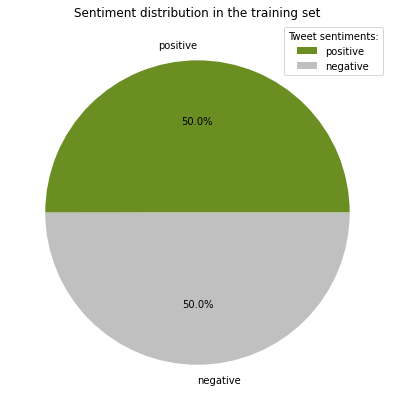

In [32]:
plt.figure(figsize=(7,7))
plt.pie(y_train.value_counts(), labels=labels, colors=colors, autopct="%1.1f%%")
plt.legend(title = "Tweet sentiments:")
plt.title("Sentiment distribution in the training set")
plt.show()

In [59]:
X_valid[:5]

array([[  938,  2505,     6,   229,    19,  5300, 23647,  1390,     3,
          226,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0],
       [  511, 16501, 31987,     2,   188,     8,    14,   587,  2103,
        65344, 65420,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0],
       [   27,   540,    22, 65344,    12,     8,    57,  2176,     9,
          103,    73,   120,  2994,   156,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
    

In [62]:
y_valid[:5]

1319643    1
642522     0
1264612    1
153376     0
1349334    1
Name: sentiment, dtype: int64

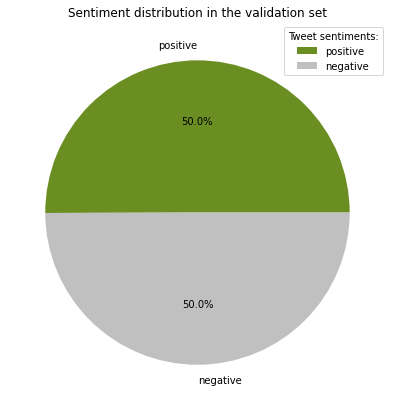

In [33]:
plt.figure(figsize=(7,7))
plt.pie(y_valid.value_counts(), labels=labels, colors=colors, autopct="%1.1f%%")
plt.legend(title = "Tweet sentiments:")
plt.title("Sentiment distribution in the validation set")
plt.show()

In [58]:
X_test[:5]

array([[31803,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0],
       [   35,    16,   570,    16,    14,    53,    17,     5,   688,
          154,  6658,  1784,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0],
       [ 1011,   801, 65344,     2,   151, 10521,   251,   532,   678,
           36,   170,  2857,   406,   314,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
    

In [63]:
y_test[:5]

181565    0
255261    0
575860    0
622569    0
654666    0
Name: sentiment, dtype: int64

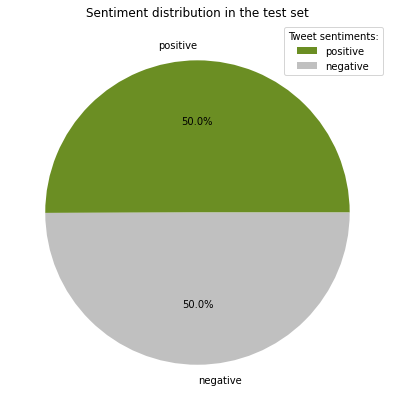

In [34]:
plt.figure(figsize=(7,7))
plt.pie(y_test.value_counts(), labels=labels, colors=colors, autopct="%1.1f%%")
plt.legend(title = "Tweet sentiments:")
plt.title("Sentiment distribution in the test set")
plt.show()

### MULTINOMIAL NAIVE BAYES

MODEL CONFIGURATION

---



In [37]:
from sklearn.naive_bayes import MultinomialNB
bayes_classifier = MultinomialNB()

MODEL TRAINING

---



In [38]:
bayes_classifier.fit(X_train, y_train)

MultinomialNB()

MODEL EVALUATION

---



In [ ]:
# y_eval = bayes_classifier.predict(X_valid)
# print(np.concatenate((y_eval.reshape(len(y_eval),1), y_valid.reshape(len(y_valid),1)),1))

In [47]:
# y_pred = bayes_classifier.predict(X_test)

# matrix = confusion_matrix(y_test, y_pred)
# print(matrix)
# accuracy_score(y_test, y_pred)

NEW PREDICTIONS

---



In [53]:
# def new_data_cleanup(data):
#     data = clean_text(data)
#     data = remove_stopwords(data)
#     data = tokenizer.encode(data)
#     return data

In [ ]:
# review = 'I love this restaurant so much'

# new_review = new_data_cleanup(review)
# new_prediction = bayes_classifier.predict(new_review)

### CONVOLUTIONAL NEURAL NETWORK

MODEL CONFIGURATION

---



MODEL TRAINING

---



MODEL EVALUATION

---



NEW PREDICTIONS

---



### RECURRENT NEURAL NETWORK

MODEL CONFIGURATION

---



MODEL TRAINING

---



MODEL EVALUATION

---



NEW PREDICTIONS

---

